In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'cat_dog_data_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [4]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [6]:
# freeze keras network
print('This is the number of trainable weights before freezing conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainalbe weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing conv base: 30
This is the number of trainalbe weights after freezing the conv base: 4


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# validation data shouldn't be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 47s 467ms/step - loss: 0.5674 - acc: 0.7145 - val_loss: 0.4985 - val_acc: 0.7730
Epoch 2/30
100/100 [==============================] - 47s 467ms/step - loss: 0.4694 - acc: 0.7875 - val_loss: 0.4523 - val_acc: 0.8100
Epoch 3/30
100/100 [==============================] - 46s 462ms/step - loss: 0.4287 - acc: 0.8105 - val_loss: 0.3968 - val_acc: 0.8270
Epoch 4/30
100/100 [==============================] - 43s 431ms/step - loss: 0.3952 - acc: 0.8250 - val_loss: 0.3964 - val_acc: 0.8310
Epoch 5/30
100/100 [==============================] - 44s 444ms/step - loss: 0.3851 - acc: 0.8305 - val_loss: 0.3533 - val_acc: 0.8540
Epoch 6/30
100/100 [==============================] - 45s 450ms/step - loss: 0.3674 - acc: 0.8290 - val_loss: 0.3555 - val_acc: 0.8410
Epoch 7/30
100/100 [==============================] - 47s 475ms/step - loss: 0.3526 - acc: 0.8415 - val_loss: 0.3583 - val_acc: 0.8520
Epoch 8/30
1

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


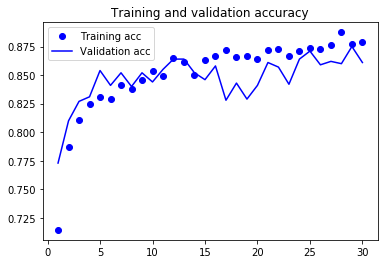

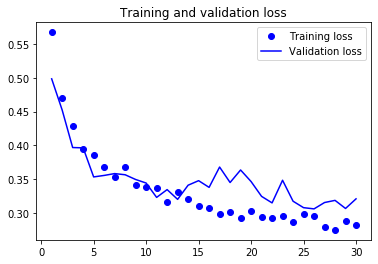

In [9]:
import matplotlib.pyplot as plt

print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()